Before you start you probably need some packages again to follow along the tutorial and the excercise. In this tutorial we will use Keras, an Application Programming Interface(API) built on the Tensorflow-library, a powerful library used mainly for neural networks. Run the cell below to check if the installation was successful. Otherwise you need to `pip install tensorflow` and maybe restart the notebook in the correct environment.

In [1]:
from keras import layers

In [2]:
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np

# Neural Network Basics

#### Neurons and Weighted Sum

The basic elements of neural networks are neurons, which are assembled in layers. In so called Dense Layers, every neuron in the previous layer is connected to every neuron in the next layer. Each neuron has its own value and each connection is assigned a weight, which are initially random. The neuron values in the next layer are calculated from values and weights of the current layer via the `Weighted Sum`:

$$ z = \sum _i w_i*x_i $$



#### Activation functions

Even with thousands of layers, this by itself would still just be linear regression. That's why the result of the weighted sum is used as input for an `activation function` next, which allows to network to mimic a non-linear function. The result from the activation function `f` will be used as the value of the neuron during the calculation of the following layer.

$$ y = f(z) $$

Common activations functions are Tanh, ReLU, Sigmoid or Linear(for output layers) functions:

![Activation functions](https://1394217531-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LvBP1svpACTB1R1x_U4%2F-LvNWUoWieQqaGmU_gl9%2F-LvO3qs2RImYjpBE8vln%2Factivation-functions3.jpg?alt=media&token=f96a3007-5888-43c3-a256-2dafadd5df7c)

The whole process so far for one input layer and one output layer with one neuron looks like this:

![Simple network](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*upfpVueoUuKPkyX3PR3KBg.png)




#### Loss function

To evaluate the quality of the prediction the loss function has to be calculated. The loss function has to be minimized to find the optimal weights.

For regression models the mean squared error(MSE) is common, similiary to linear to regression:

$$ \mathcal{L}_{MSE} = \frac{1}{2*n_{samples}} \sum _i ^{n_{samples}}(y_{true, i} - y_{pred, i})^2 $$


For classification models the log-loss aka cross-entropy-loss, which we already encountered during the logistic regression in it's simpler binary form, is usually applied:

$$ \mathcal{L}_{CE} = - \frac{1}{n_{samples}} \sum _i ^{n_{samples}} \sum _c ^{n_{classes}} is\_from_\_class\_c * log(y_{pred, c, i}) $$

`is_from_class_c` is either 0 or 1, depending if the i-th sample belongs to class c or not. $y_{pred, c, i}$ is the predicted probability for the i-th sample to belong to class c. You might recall, that the `softmax` function converts any set of value into probabilities and is therefore used as final layer in classification models, similiar to the final linear layer in regression models.


#### Backprogapation

The heart of neural networks is backpropagation. During backprogation the weights of each layer will be improved to get a better prediction in the next epoch.

To achieve this the loss function has to be minimized. Therefore we need the derivations of the loss function with regard to all the weights, and then apply the negative gradients with a prefactor $\eta$, the learning rate, on top of the current weights in order to optimimize them (Gradient Descent):

$$ w^{epoch\ l+1} = w^{epoch\ l} - \eta \frac{\partial \mathcal{L}}{\partial w^{epoch\ l}} $$

How to get the gradient of the loss function with regard to each weight? Using the chain rule makes it quite bearable. Here's how you can split the derivation in our simple 2-layer network, assuming $n_{samples} = 1$, for the specific weight $w_k$:

$$ \frac{\partial \mathcal{L}}{\partial w_{k}} = \frac{\partial \mathcal{L}}{\partial y_{pred}} \frac{\partial y_{pred}}{\partial z} \frac{\partial z}{\partial w_k} $$

All of these derivations are easily calculatable, even if the interchangable activation function might look scary, but all of the typical activation function have easily available derivations as well. Here's how they wwould look like assuming MSE as loss and ReLU as activation function 

$$\frac{\partial \mathcal{L}}{\partial y_{pred}} = \frac{1}{n_{samples}} (y_{true} - y_{pred})$$
$$\frac{\partial y_{pred}}{\partial z} = \begin{cases}
1 \text{, if z > 0}\\
0\text{, otherwise}\\
\end{cases} $$
$$ \frac{\partial z}{\partial w_k} = \frac{\partial (w_1x_1 + w_2x_2 + ... + w_kx_k + ... + w_nx_n)}{\partial w_k} = x_k $$



If our x-layer was a hidden layer and we had an even earlier layer v, than the gradient with regard any weight $w_l$ of the v-layer would only change slightly, as we can reuse the gradients from the x-layer (therefore BACKpropagation). I'll change the notation here, to mark all the results from the x-layer with a x-superscript and all the results from the v-layer with a v-superscript.

$$ \frac{\partial \mathcal{L}}{\partial w_{l}} = \frac{\partial \mathcal{L}}{\partial y^x_{pred}} \frac{\partial y^x_{pred}}{\partial z^x} \frac{\partial z^x}{\partial y^v} \frac{\partial y^v}{\partial z^v} \frac{\partial z^v}{\partial w_l}$$

Here $\frac{\partial \mathcal{L}}{\partial y^x_{pred}} \frac{\partial y^x_{pred}}{\partial z^x}$ can be reused from the previous layer and $\frac{\partial y^v}{\partial z^v} \frac{\partial z^v}{\partial w_l}$ can be treated just as we treated the x-layer. So the only thing we have to consider additionally for the earlier weights is the $\frac{\partial y^v}{\partial z^v}$ term.

More generally we have to consider the dimenions of each derivation. When expressing the weighted sum as a vector-product. The derivation in this form is a little more obvious.

$$ \sum _i w_i*x_i = \mathbf{w} * \mathbf{x} $$
$$ \frac{\partial \mathbf{z}^x}{\partial \mathbf{y}^v} = \frac{\partial (\mathbf{w}^v * \mathbf{y}^v)}{\partial \mathbf{y}^v} = \mathbf{w}^v $$





# Convolutional Neural Networks Tutorial

### The MNIST numbers dataset

The MNIST-numbers dataset is a good place to start with CNNs as it's easy to judge the correctness of the predictions for us. The dataset consists of 28x28 pixel images of handwritten numbers in greyscale values. It's split in 60k images for training and 10k images for testing.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(60000, 28, 28), y=(60000,)


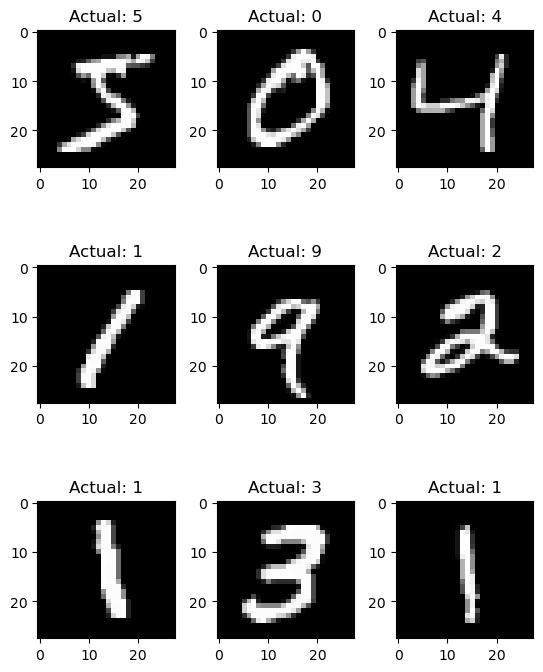

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# confirm dataset size and shape
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test: X={X_train.shape}, y={y_train.shape}")
# plot first 9 images
fig, axs = plt.subplots(3, 3)
plt.subplots_adjust(top=1.5,wspace=0.3)
for i in range(3):
    for j in range(3):
        ax = axs[i,j]
        ax.imshow(X_train[i*3+j], cmap=plt.get_cmap('gray'))
        ax.set_title(f"Actual: {y_train[i*3+j]}")
   
plt.show()

### Data manipulation

Training a neural network can be time-intensive. To reduce the amount of weight updates needed until convergence it's useful to scale the data. We will use a MinMax-Scaler to to bring the greyscale-values(ranging from 0 to 255) to values between 0 and 1. MinMax-Scaler will try to scale each column of the inputs, so we will flatten the data and restore the original shape afterwards(* before a tuple unpacks the values) and add an additional dimension for the color-channel, which in our case is 1 as we only have greyscale-data.

Also we want to predict the 10 classes of numbers, but only have 1 single output for each picture so far. To get 10 outputs we will one-hot-encode our y-values. This means every value is zero, but the class that the value belongs to. So if the picture shows a 4, then the fifth value in the output-array will be 1 and the remaining nine values will be zero, as 4 is the fifth integer counting the 0.

In [4]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape((-1,1))).reshape((*X_train.shape,1))
X_test_scaled = scaler.transform(X_test.reshape((-1,1))).reshape(*(X_test.shape),1)
print("Unscaled max:", np.max(X_train))
print("Unscaled min:", np.min(X_train))
print("Scaled max:", np.max(X_train_scaled))
print("Scaled min:", np.min(X_train_scaled))

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
print("Output-shape before transformation:", y_train.shape)
print("Output-shape after transformation:", y_train_categorical.shape)
print("Example outputs:", y_train[0], y_train_categorical[0])

Unscaled max: 255
Unscaled min: 0
Scaled max: 1.0
Scaled min: 0.0
Output-shape before transformation: (60000,)
Output-shape after transformation: (60000, 10)
Example outputs: 5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Creating the model

Convolutional neural networks mainly depend on two special layers: the Convolutional Layer and the Pooling Layer
![Convolutional Layer](https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_02_17A-ConvolutionalNeuralNetworks-WHITEBG.png)

![Pooling Layer](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

In convolutional layers a $ n\cdot m$-shaped filter is defined. The output is the sum of the element-wise products of input and filter. After each calculation the filter is moved to the right or down with a certain stride length(Schrittweite). To avoid pixel-cutoffs by too wide filters at the end of a line, it's possible to pad your data. While training, the entries in the filter will be changed.

In pooling layers a $ n\cdot m$-section of the input is considered. For different types of pooling layers different operations may be applied to these sections. A common pooling layer is max-pooling, where only the maximal number of the section will be passed to the output.

First will use a single convolutional layer, which applies 5 filters of 3x3-shape, which will move in 3x3-strides(3 steps to the right and 3 steps down, if end of the line is reached), with a relu-activation-function on the 28x28-pixel images.

Then we will pool the results with a MaxPooling-layer of shape 2x2 and 1x1-strides(default-setting).

The resulting matrix(whatever shape it was by now) will be flattened into a single array and fed into a small fully-connected neural network with a 100-neuron-layer and a 10-neuron-output-layer. As we have to deal with a classification problem here, the final layer has to have the same amount of neuron as we have classification-classes. Also we will use a softmax-activation-function in the end, so that the result can be interpreted as probabilities.

In [5]:
model = Sequential(name="Conv_Net")
model.add(layers.InputLayer(input_shape=(28, 28, 1)))
model.add(layers.Conv2D(filters=5, kernel_size=(3, 3), strides=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "Conv_Net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 5)           50        
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 5)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 100)               8100      
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 9160 (35.78 KB)
Trainable params: 9160 (35.78 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

Now we have to add the loss-function(Mean-Squared-Error for regression or Cross-Entropy Loss for classification) and the optimizer that we like prefer(e.g. Gradient Descent, Stochastic Gradient Descent(SGD), Adaptive Moment Estimation(Adam)) during the compilation of the model. We can also add the metrics, that we want to track during the training.

The optimizer also needs a learning-rate, by which the gradients are multiplied.

In [6]:
my_optimizer = Adam(learning_rate=0.0005)
my_loss = CategoricalCrossentropy()
my_metrics = ["accuracy"]

model.compile(
    loss = my_loss,
    optimizer = my_optimizer,
    metrics = my_metrics
    )

### Training the model

Now we can start the training with forward pass, result evaluation and finally the backward pass to update the weights. All of this is done in a single function in tensorflow: fit. Fit will return a History-object, from which the results of the training for each epoch can be accessed. You must also supply the function with inputs and outputs. The amount of epochs can be specified. The batch_size determines how many examples are seen at once, which reduces the required runs per epoch.
If you want to, you can split an additional portion from the training_data for validation and shuffle the data after each epoch. To suppress the output of the training, set verbose to 0.

In [7]:
history = model.fit(
                    x=X_train_scaled,
                    y=y_train_categorical,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1,
                    shuffle=True,
                    verbose=1)

Epoch 1/20
422/422 [==============================] - 3s 5ms/step - loss: 1.2324 - accuracy: 0.6250 - val_loss: 0.6305 - val_accuracy: 0.8120
Epoch 2/20
422/422 [==============================] - 2s 5ms/step - loss: 0.5843 - accuracy: 0.8225 - val_loss: 0.4263 - val_accuracy: 0.8690
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.4465 - accuracy: 0.8642 - val_loss: 0.3421 - val_accuracy: 0.8980
Epoch 4/20
422/422 [==============================] - 2s 5ms/step - loss: 0.3733 - accuracy: 0.8861 - val_loss: 0.2937 - val_accuracy: 0.9105
Epoch 5/20
422/422 [==============================] - 2s 5ms/step - loss: 0.3279 - accuracy: 0.8988 - val_loss: 0.2656 - val_accuracy: 0.9203
Epoch 6/20
422/422 [==============================] - 2s 5ms/step - loss: 0.2970 - accuracy: 0.9089 - val_loss: 0.2452 - val_accuracy: 0.9283
Epoch 7/20
422/422 [==============================] - 2s 5ms/step - loss: 0.2764 - accuracy: 0.9151 - val_loss: 0.2309 - val_accuracy: 0.9308
Epoch 

### Evaluating the model

Lastly you should evaluate, how the training progressed and how precise the model classifies the handwritten digits. 

Let's have a look at the training. Is the model converged or do we need more epochs?

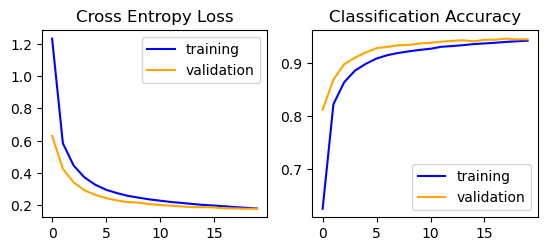

In [8]:
plt.subplot(1, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='training')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='training')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.subplots_adjust(top=0.5)
plt.show()

Let's move on to the predictions of the test-set. We can calculate our requested metrics of the model with `evaluate`. The probabilities can be calculated with model.predict, but we will need the maximum value of the probabilities. In this special case, this will actually be the prediction of the datapoint, but in others cases you might still have to use the index of the maximum probability as the index of a list of your classes complete the prediction. So we will go through these motions here as well. We can use this information to plot the confusion-matrix.

Loss:  0.19
Accuracy:  0.94
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.94      0.95      1032
           3       0.90      0.95      0.92      1010
           4       0.96      0.95      0.96       982
           5       0.90      0.94      0.92       892
           6       0.96      0.97      0.97       958
           7       0.94      0.94      0.94      1028
           8       0.91      0.83      0.87       974
           9       0.91      0.93      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



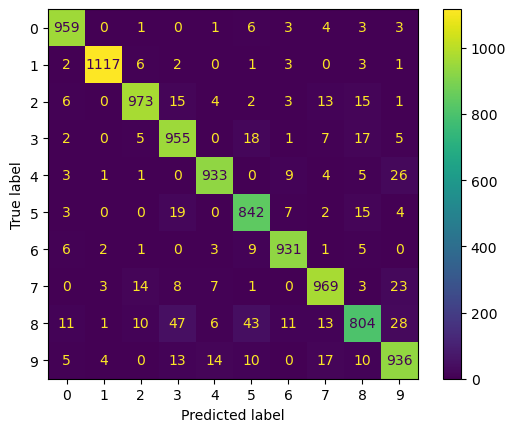

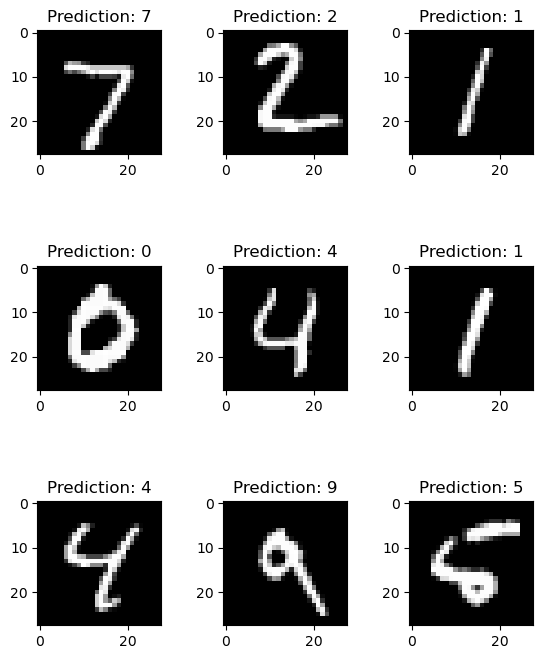

In [9]:
loss, acc = model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"Loss: {loss: .2f}")
print(f"Accuracy: {acc: .2f}")

classes = list(range(10))
probabilities = model.predict(X_test_scaled, verbose=0)
max_probability = np.argmax(probabilities, axis=1) # returns the index of the maximal value, e.g. [0.1, 0.2, 0.0, 0.6, 0.1] --> 3
class_prediction = [classes[max_probability_index] for max_probability_index in max_probability]

print(classification_report(y_test, class_prediction))

cm = confusion_matrix(y_test, class_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

fig, axs = plt.subplots(3, 3)
plt.subplots_adjust(top=1.5,wspace=0.5)
for i in range(3):
    for j in range(3):
        ax = axs[i,j]
        ax.imshow(X_test[i*3+j], cmap=plt.get_cmap('gray'))
        ax.set_title(f"Prediction: {class_prediction[i*3+j]}")
